In [ ]:
# Import the API
import ee

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-xxxx-test')

In [ ]:
# Import the necessary libraries
import geemap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geemap import chart

# Modeling AGBD using Random Forests
## Prepare training and testing data
Next, split training datasets into training and testing sets. Then check the size of the training and testing data.


In [ ]:
# Split the data into 70% training and 30% testing
ta_points_random = filteredPoints.randomColumn('random')
training = ta_points_random.filter(ee.Filter.lte('random', 0.7))
testing = ta_points_random.filter(ee.Filter.gt('random', 0.7))

# Check training data set
print(training.size().getInfo())
print(training.first().getInfo())

# Check the size of the testing data
print(testing.size().getInfo())
print(testing.first().getInfo())

21543
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [28.879554949225398, -18.486917895039422]}, 'id': '6', 'properties': {'agbd': 61.624183654785156, 'random': 0.29031444272248386}}
9242
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [28.887129855174432, -18.486932878169007]}, 'id': '11', 'properties': {'agbd': 57.52329635620117, 'random': 0.7412221183650421}}


In [ ]:
# Define the range of scales to test
scales = [10, 20, 30, 50, 100, 200]  # in meters

# Define the predictor ('variables') and response ('label') features
predictors = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12','NDVI', 'SAVI','RESI', 'elevation', 'slope']
response = 'agbd'

# Function analyze scale
def analyze_scale(scale):
    sampled = clippedmergedCollection.sampleRegions(**{
        'collection': training,
        'scale': scale,
        'properties': [response],
        'geometries': True
    })

    model = ee.Classifier.smileRandomForest(**{
        'numberOfTrees': 50
    }).setOutputMode('REGRESSION').train(**{
        'features': sampled,
        'classProperty': response,
        'inputProperties': predictors
    })

    # Predict validation
    prediction = clippedmergedCollection.classify(model).rename('predictedValue')

    validation = prediction.sampleRegions(**{
        'collection': testing,
        'properties': [response],
        'scale': scale
    })

    # Get observed and predicted values
    observed = validation.aggregate_array(response).getInfo()
    predicted = validation.aggregate_array('predictedValue').getInfo()

    # Calculate RMSE
    rmse = [(obs - pred) ** 2 for obs, pred in zip(observed, predicted)]
    mse = sum(rmse) / len(rmse)
    rmse_result = mse ** 0.5

    # Calculate R²
    mean_observed = sum(observed) / len(observed)
    ss_tot = sum((obs - mean_observed) ** 2 for obs in observed)
    ss_res = sum(rmse)
    r_squared = 1 - (ss_res / ss_tot)

    return {
        'RMSE': rmse_result,
        'R2': r_squared
    }

# Map the analyze_scale function over the scales array and handle results
results = [analyze_scale(scale) for scale in scales]

# Function to print results
def handle_results(computed_results):
    for index, result in enumerate(computed_results):
        print(f'Scale: {scales[index]} - RMSE: {result["RMSE"]}, R²: {result["R2"]}')

# Handle the results
handle_results(results)

Scale: 10 - RMSE: 13.808658003910963, R²: 0.4610020760720003
Scale: 20 - RMSE: 10.946823081475477, R²: 0.6612647887592074
Scale: 30 - RMSE: 9.240366898395886, R²: 0.7586415120524851
Scale: 50 - RMSE: 8.406822561737822, R²: 0.8002218867387657
Scale: 100 - RMSE: 9.663668017777685, R²: 0.7360217478800495
Scale: 200 - RMSE: 11.661777746612584, R²: 0.6154009345092291


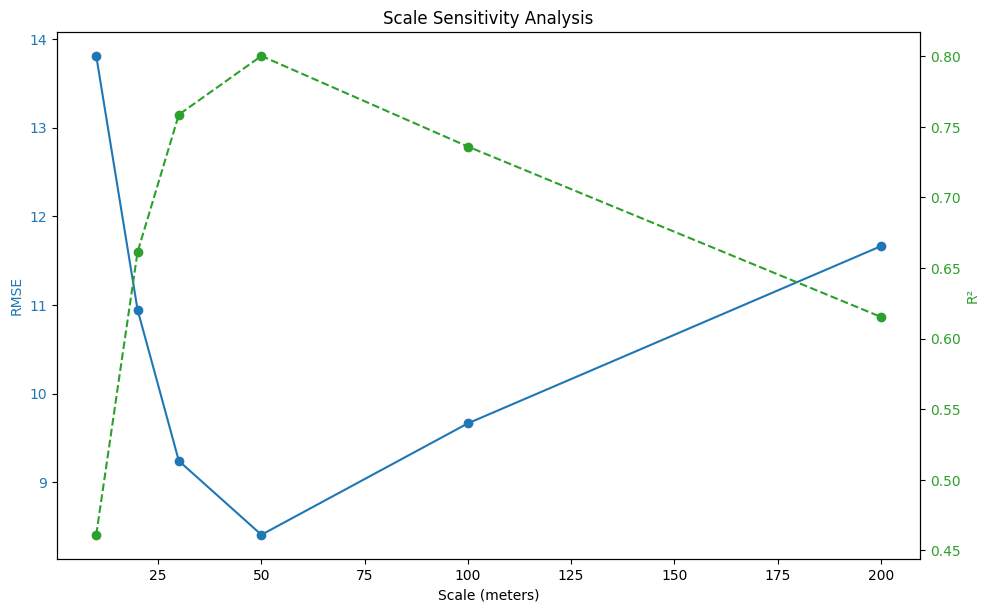

In [ ]:
# Map the analyze_scale function over the scales array and handle results
# results = [analyze_scale(scale) for scale in scales]

# Extract RMSE and R² values for plotting
rmse_values = [result['RMSE'] for result in results]
r2_values = [result['R2'] for result in results]

# Plot the results
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Scale (meters)')
ax1.set_ylabel('RMSE', color=color)
ax1.plot(scales, rmse_values, color=color, marker='o', label='RMSE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('R²', color=color)  # we already handled the x-label with ax1
ax2.plot(scales, r2_values, color=color, marker='o', linestyle='--', label='R²')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Scale Sensitivity Analysis')
plt.show()

In [ ]:
# Initialize the map
map6 = geemap.Map()
map6.centerObject(boundary, 12)

# For each scale, predict and display results
for scale in scales:
    model = ee.Classifier.smileRandomForest(**{
        'numberOfTrees': 50
    }).setOutputMode('REGRESSION').train(**{
        'features': clippedmergedCollection.sampleRegions(**{
            'collection': testing,
            'scale': scale,
            'properties': [response],
            'geometries': True
        }),
        'classProperty': response,
        'inputProperties': predictors
    })

    prediction = clippedmergedCollection.classify(model)

    viz = {
        'min': 0,
        'max': 120,  # Adjust based on expected range of your data
        'palette': ['#FFFF00', '#ADFF2F', '#32CD32', '#2E8B57', '#006400']
    }
    map6.addLayer(prediction, viz, 'Prediction at scale {}'.format(scale))

# Add color bar to the map
map6.add_colorbar(viz, label="AGBD (Mg/ha)", layer_name="AGBD map")

# Display the map
map6.addLayerControl()
map6

Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…